In [2]:
import torch
import os



# GPU 할당 변경하기
GPU_NUM = 4  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check



Current cuda device  4


In [3]:
import time
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

### nomalization 

In [15]:
def normalization( x:(2,257,382), y:(2,257,382) ):
    data  = np.concatenate([x[0], x[1]], 1) #(257, 382*2)
    label = np.concatenate([y[0], y[1]], 1) #(257, 382*2)
    
    
    """StandardScaler"""
    D_L = np.concatenate([data, label], 0) #(257*2, 382*2)
    D_L = scaler.fit_transform(D_L)
    
    res_data = D_L[:257, :]  # (257, 382*2)
    res_label = D_L[257:, :] # (257, 382*2)
    
    data_L  = res_data[:,:382].reshape(1,257,382)
    data_R  = res_data[:,382:].reshape(1,257,382)
    label_L = res_label[:,:382].reshape(1,257,382)
    label_R = res_label[:,382:].reshape(1,257,382)
    
    
    data_  =  np.concatenate([data_L,  data_R], 0)
    label_ =  np.concatenate([label_L, label_R],0)
    
    data_  = data_.reshape(1,2,257,382)
    label_ = label_.reshape(1,2,257,382)
    
    return  torch.as_tensor(data_).to('cuda:3'), torch.as_tensor(label_).to('cuda:5')

In [16]:
x_data = np.load('data_label/x_data.npy')
y_data = np.load('data_label/y_data.npy')

In [17]:
x_data.shape

(2210, 2, 257, 382)

In [18]:
scaled_x = torch.empty(1,2,257,382).to('cuda:3')
scaled_y = torch.empty(1,2,257,382).to('cuda:5')

scaler = StandardScaler()


num = x_data.shape[0]
for idx in range(num):
    cln_noise, noise = x_data[idx,:,:,:], y_data[idx,:,:,:]
    x_element, y_element = normalization(cln_noise, noise)
    
    scaled_x = torch.cat([scaled_x, x_element], axis=0)
    scaled_y = torch.cat([scaled_y, y_element], axis=0)
    

scaled_x = scaled_x[1:,:,:,:].reshape(2210,2,257,382).to('cuda:3')
scaled_y = scaled_y[1:,:,:,:].reshape(2210,2,257,382).to('cuda:3')


scaled_x.shape, scaled_y.shape

(torch.Size([2210, 2, 257, 382]), torch.Size([2210, 2, 257, 382]))

In [3]:
# x_data = np.load('data_label/x_data.npy')
# y_data = np.load('data_label/y_data.npy')

# xy = torch.empty(1,257,382*2).to('cuda:3')
# xy_data = np.concatenate([x_data, y_data], axis=2 )
# scaler = StandardScaler()


# num = x_data.shape[0]
# for idx in range(num):
#     scaled_xy = scaler.fit_transform(xy_data[idx,:,:])
#     scaled_xy = torch.as_tensor( scaled_xy ).reshape(1,257,382*2).to('cuda:3')
#     xy = torch.cat([xy, scaled_xy],axis=0)


# scaled_x = xy[1:,:,:382].reshape(2210,1,257,382).to('cuda:3')
# scaled_y = xy[1:,:,382:].reshape(2210,1,257,382).to('cuda:3')

# scaled_x.shape, scaled_y.shape

(torch.Size([2210, 1, 257, 382]), torch.Size([2210, 1, 257, 382]))

In [21]:
train_size = 2210
full_dataset = TensorDataset(scaled_x.float().to(device), scaled_y.float().to(device))
train_dataset = DataLoader( dataset=full_dataset, batch_size = 20)
                           #shuffle=True, drop_last=True)


### model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F



def conv_trans_block( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        # (H-1)*2 -2*1 + 1*(3-1) +1 +1 = 2*H
        nn.BatchNorm2d(out_dim),
        act_fn)
    return model


# (H,W) -> (H/2, W/2)
def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
        nn.Conv2d(out_dim, out_dim, kernel_size=3,  padding=1),
        nn.BatchNorm2d(out_dim),
        )
    return model


def conv_input( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=(3,2), padding=1), # H, W+1
            nn.BatchNorm2d(out_dim),
            act_fn,
            nn.Conv2d(out_dim, out_dim, kernel_size=(2,2),  padding=(0,1)), # H-1, W+1
            nn.BatchNorm2d(out_dim),
            )
    return model


def conv_output( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=(3,4), padding=(1,1)), # H, W-1
            nn.BatchNorm2d(out_dim),
            act_fn,
            nn.Conv2d(out_dim, out_dim, kernel_size=(2,4),  padding=(1,1)), # H+1, W-1
            nn.BatchNorm2d(out_dim),
            )
    return model


def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)
        

In [23]:
class UnetGenerator(nn.Module):
    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)
        
        
        self.down_1 = conv_input(self.in_dim, self.num_filter*1, act_fn) #(257,382) -> (1,256,384)
        self.pool_1 = maxpool() #(1,256,384) -> (1,128,192)
        self.down_2 = conv_block(self.num_filter*1, self.num_filter*2, act_fn) 
        self.pool_2 = maxpool() #(1,128,192) -> (2,64,96)
        self.down_3 = conv_block(self.num_filter*2, self.num_filter*4, act_fn)
        self.pool_3 = maxpool() #(2,64,96) -> (4,32,48)
        self.down_4 = conv_block(self.num_filter*4, self.num_filter*8, act_fn)
        self.pool_4 = maxpool() #(4,32,48) -> (8,16,24)
        self.bridge = conv_block(self.num_filter*8, self.num_filter*16, act_fn) #(8,32,48) -> (16,16,24)
        
    
        self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
        self.up_1 = conv_block(self.num_filter*16, self.num_filter*8, act_fn) #(16,16,24) -> (8,32,48)    
        self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
        self.up_2 = conv_block(self.num_filter*8, self.num_filter*4, act_fn) #(8,32,48)  -> (4,64,96)
        self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
        self.up_3 = conv_block(self.num_filter*4, self.num_filter*2, act_fn) #(4,64,96)  -> (2,128,192)
        self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
        self.up_4 = conv_output(self.num_filter*2, self.num_filter*1, act_fn) #(2,128,192) -> (1,257,382)
        
        self.out = nn.Sequential(
                nn.Conv2d(self.num_filter, self.out_dim, kernel_size=3, padding=1),
                nn.Tanh()
        )
        
        
    def forward(self, input):

        #(N,1,257,382)
        down_1 = self.down_1(input)  #(N,1*C,256,384)
        pool_1 = self.pool_1(down_1) #(N,1*C,128,192)        
        down_2 = self.down_2(pool_1) 
        pool_2 = self.pool_2(down_2) #(N,2*C,64,96)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3) #(N,4*C,32,48)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4) #(N,8*C,16,24)

        bridge = self.bridge(pool_4) #(N,16*C,16,24)

        trans_1  = self.trans_1(bridge) #(N,8*C,32,48)
        concat_1 = torch.cat([trans_1, down_4], dim=1) #(N,16*C,32,48)
        up_1     = self.up_1(concat_1) #(N,8*C,32,48)
        trans_2  = self.trans_2(up_1)  #(N,4*C,64,96)
        concat_2 = torch.cat([trans_2, down_3], dim=1) #(N,8*C,64,96)
        up_2     = self.up_2(concat_2) #(N,4*C,64,96)
        trans_3  = self.trans_3(up_2)  #(N,2*C,128,192)
        concat_3 = torch.cat([trans_3, down_2], dim=1)  #(N,4*C,128,192)
        up_3     = self.up_3(concat_3) #(N,2*C,128,192)
        trans_4  = self.trans_4(up_3)  #(N,C,256,384)
        concat_4 = torch.cat([trans_4, down_1], dim=1)  #(N,2*C,256,384)
        up_4     = self.up_4(concat_4) #(N,C,257,382)

        out = self.out(up_4)

        return out


In [27]:
from collections import OrderedDict

num_filter=64
epoch=70
lr=0.00001

# checkpoint = torch.load('Unet2')
# state_dict =checkpoint['model_state_dict']

# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     name = k[7:] # remove 'module.' of dataparallel
#     new_state_dict[name]=v

    
# model = UnetGenerator(in_dim=2, out_dim=2, num_filter=num_filter).to(device)
# model.load_state_dict(new_state_dict)
# model.apply(init_weights)
# model = nn.DataParallel(model, device_ids=[4,5,1], output_device=4)
#model = model.cuda()


model = UnetGenerator(in_dim=2, out_dim=2, num_filter=num_filter)
# model.load_state_dict(new_state_dict)
# model.apply(init_weights)
model = nn.DataParallel(model, device_ids=[4,5,1,2], output_device=4)
model = model.cuda()


loss_func = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [45]:

model.train()
for i in range(epoch):
    s = time.time()
    for (data,label) in train_dataset:
        (data, label) = (data.to(device), label.to(device))
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = loss_func(output,label)
        loss.backward()
        
        optimizer.step()
    
    if i%10 == 9 or i==0:
        print('epoch:' + str(i+1) + ',  Loss: {:.3f},  time: {:.3f}sec'.format( loss.item(), time.time()-s ))
        

epoch:1,  Loss: 0.268,  time: 32.891sec
epoch:10,  Loss: 0.261,  time: 33.395sec


In [47]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'Unet3')

### result

In [43]:
idx=5
LorR = 0

<IPython.core.display.Javascript object>


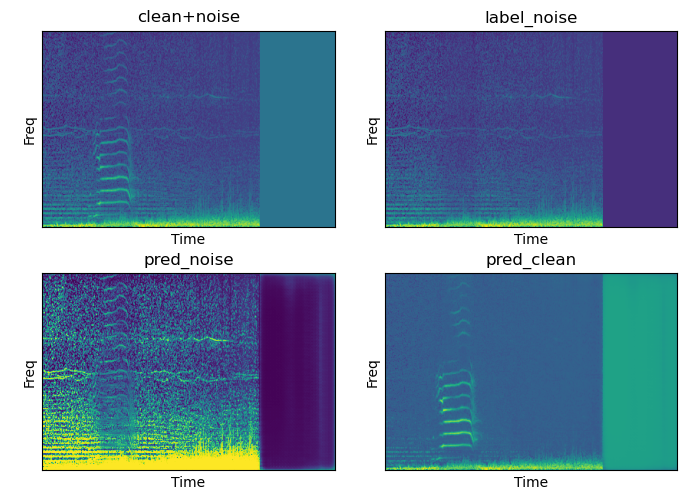

In [44]:
%matplotlib notebook

label_  = label[idx][LorR].to('cpu').detach().numpy().reshape(257,382)
output_ = output[idx][LorR].to('cpu').detach().numpy().reshape(257,382)
input_  = data[idx][LorR].to('cpu').detach().numpy().reshape(257,382)

pred_clean = input_ - output_


x = [ input_, label_, output_, pred_clean]
title=['clean+noise', 'label_noise', 'pred_noise', 'pred_clean']

fig = plt.figure(figsize=(7,5))
row, col = 2,2

for i,mag in enumerate(x):
    ax = fig.add_subplot(row, col, i+1)
    im = ax.imshow(mag, origin='lower')
    ax.set_title(title[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Freq')
    ax.set_xticks([]), ax.set_yticks([])
    #fig.colorbar(im, shrink=0.7)

plt.tight_layout()
plt.savefig('pred_noise.png')
plt.show()